In [31]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import numpy as np
import os, sys, pickle
# from tqdm import tqdm

sys.path.append( os.path.dirname( os.path.abspath('') ) )

from utils.utils import adaptive_integration, p_nu, p_nu_single, f
from DM_theory.functions import get_nu_bar, get_q

from empirical.readData import *
from inference.BayesModel import *

from ipywidgets import interact

%matplotlib ipympl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
mP = ModelParams(mode='artificial',gamma=1.7,delta=4.5,nu_max=25.,T=100,N=500)
BM = BayesModel(mP)
BM.prepare_data(mP,mode='rates')
BM.set_priors(two_pop=False)

my_logl = BM.set_logl(withZeros=True)
my_logl(np.array([1.5,4.5,30.]))

1.5959540910682242 0.004052847345693511 7.642153648172551
inferred parameters: options['rateWnt']=1.5959540910682242, options['tau_I']=[0.004052847345693511], options['alpha_0']=0.03465009847570357


array([-3688.68427855])

In [12]:
# steps = 201
# gamma_arr = np.linspace(1.,2.5,steps)
# delta_arr = np.linspace(1.,10.,steps)
# nu_max = 25.
# gamma_mesh,delta_mesh = np.meshgrid(gamma_arr,delta_arr)

# logl_mesh = np.zeros((steps,steps))
# for j in range(steps):
#     logl_mesh[:,j] = my_logl(np.vstack([gamma_mesh[:,j],delta_mesh[:,j],np.full(steps,nu_max)]).T)
# logl_mesh

In [13]:
ref_values = {
    'gamma': 1.5,
    'delta': 4.5,
    'nu_max': 25.,
    'T': 10,
    'N': 50
}
results = []
for g,gamma in enumerate([1.7,2.1]):
    ref_values['gamma'] = gamma
    mP = ModelParams(mode='artificial',**ref_values)
    BM, res, sampler = run_sampling(mP)
    results.append(res)

1.5959540910682242 0.004052847345693511 7.642153648172551
inferred parameters: options['rateWnt']=1.5959540910682242, options['tau_I']=[0.004052847345693511], options['alpha_0']=0.03465009847570357
3.4734711564679754 0.004052847345693511 22.01299572977984.0815]*| it/evals=3080/10779 eff=28.1337% N=240 40 0  
inferred parameters: options['rateWnt']=3.4734711564679754, options['tau_I']=[0.004052847345693511], options['alpha_0']=0.02451743620903544


{'gamma': 1.7, 'delta': 4.5, 'nu_max': 25.0, 'T': 10, 'N': 50}
{'gamma': 2.1, 'delta': 4.5, 'nu_max': 25.0, 'T': 10, 'N': 50}


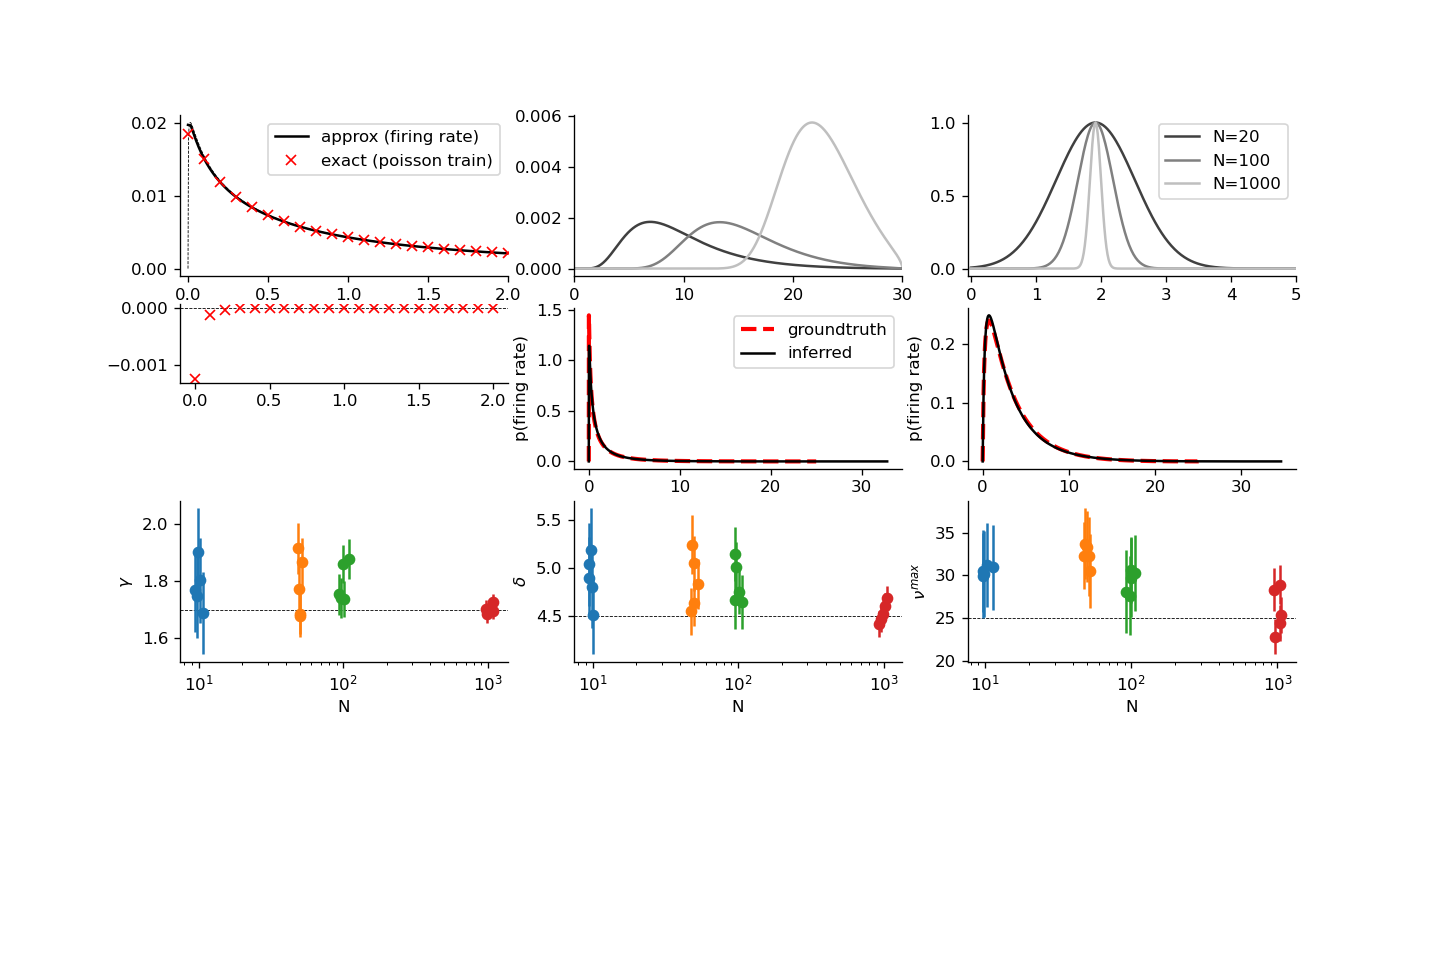

In [42]:

'''
    define the figure as should be plotted for the paper
'''
steps = 20
params = {
    'gamma': 1.7,
    'delta': 4.5,
    'nu_max': 30.,
    'T': 60.,
    'N': 100,
    'nAnimals': 5
}

params['weight_dark'] = 0.5
params['gamma_dark'] = params['gamma']
params['delta_dark'] = 4.5

offset = 0.5/params['T']
two_pop = False

fig = plt.figure(figsize=(12,8),dpi=120)

ax_logp_points = fig.add_subplot(431)
ax_logp_points_error = fig.add_subplot(837)
ax_logp_max = fig.add_subplot(432)
ax_logp_mean = fig.add_subplot(433)


N_max = int(100*params['T'])
nu_array = np.linspace(0,N_max/params['T'],N_max+1)

nu_full = np.linspace(0,params['nu_max'],10001)
p_full = p_nu(nu_full,params,two_pop=two_pop) / params['T']


## count based
N_max_steps = np.ceil(2*params['T']/steps)*steps
rateWnt_array = np.linspace(0,N_max_steps/params['T'],steps+1)
p_N_AP = np.zeros(steps+1)
for r,rateWnt in enumerate(rateWnt_array):
    p_N_AP[r] = adaptive_integration(f,0,params['nu_max'],
        args=(params,np.array([rateWnt*params['T']]),params['T'],two_pop)
    )

# p_N_AP_cont = (p_nu(nu_array[:-1],params,two_pop=two_pop) + p_nu(nu_array[1:],params,two_pop=two_pop)) / (2*params['T'])
p_N_AP_cont = p_nu(nu_array+offset,params,two_pop=two_pop)/ params['T']
p_N_AP_cont_points = p_nu(rateWnt_array + offset,params,two_pop=two_pop) / params['T']

ax_logp_points.plot(nu_full,p_full,'k--',linewidth=0.5)
ax_logp_points.plot(nu_array,p_N_AP_cont,'k',label='approx (firing rate)')
# ax_logp_points.plot(rateWnt_array,p_N_AP_cont_points,'rx')
ax_logp_points.plot(rateWnt_array,p_N_AP,'rx',label='exact (poisson train)')

p_N_AP_error = p_N_AP - p_N_AP_cont_points
ax_logp_points_error.axhline(0,color='k',linestyle='--',linewidth=0.5)
ax_logp_points_error.plot(rateWnt_array,p_N_AP_error,'rx')

plt.setp(ax_logp_points,xlim=[-0.05,2])



### plotting extreme value distribution
### and mean
for n, nNeurons in enumerate([20,100,1000]):
    ## ... extreme value distribution
    p_N_AP_cum = np.pad(
        np.cumsum(p_N_AP_cont)**nNeurons,
        (1,0),mode='constant',constant_values=0
    )
    # print(p_N_AP_cum, p_N_AP_cum.shape)
    p_extreme = np.diff(p_N_AP_cum)
    p_extreme *= (1 - 1./(params['nu_max']-nu_array+1)**2)
    ax_logp_max.plot(nu_array,p_extreme,color=[(n+1)/4]*3)

    
    ## ... and mean
    nu_mean = get_nu_bar(params['gamma'],params['delta'],params['nu_max'])
    nu_SD = get_q(params['gamma'],params['delta'],params['nu_max'])

    nu_sigma = np.sqrt(nu_SD - nu_mean**2) / np.sqrt(nNeurons)
    # print(f'{nu_mean=}, {nu_SD=}, {nu_sigma=}')

    mean_distribution = np.exp(-(nu_array- nu_mean)**2 / (2*nu_sigma**2)) # 1/np.sqrt(2*np.pi*nu_sigma**2) 
    ax_logp_mean.plot(nu_array,mean_distribution,color=[(n+1)/4]*3, label=f'N={nNeurons}')

plt.setp(ax_logp_mean,xlim=[-0.05,5],xlabel='$\\bar{\\nu}$')
plt.setp(ax_logp_max,xlim=[-0.05,params['nu_max']],xlabel='$\\nu$')
ax_logp_mean.legend()
ax_logp_points.legend()

for axx in [ax_logp_points,ax_logp_points_error,ax_logp_max,ax_logp_mean]:
    axx.spines[['top','right']].set_visible(False)


ref_values = {
    'gamma': 1.5,
    'delta': 4.5,
    'nu_max': 25.,
    'T': 10,
    'N': 50
}

nu_array = np.linspace(0,50,10001)

for g,gamma in enumerate([1.7,2.1]):
    ax_compare = fig.add_subplot(4,3,5+g)
    ref_values['gamma'] = gamma
    # mP = ModelParams(mode='artificial',**ref_values)
    # BM, results, sampler = run_sampling(mP)
    print(ref_values)
    ax_compare.plot(nu_array,p_nu_single(nu_array,ref_values['gamma'],ref_values['delta'],ref_values['nu_max']),'r--',linewidth=2.5,label='groundtruth' if g==0 else None)
    ax_compare.plot(nu_array,p_nu_single(nu_array,*results[g]['posterior']['mean']),'k-',label='inferred' if g==0 else None)
    plt.setp(ax_compare,xlabel='firing rate',ylabel='p(firing rate)')
    ax_compare.spines[['top','right']].set_visible(False)
    if g==0:
        ax_compare.legend()

res = pickle.load(open('../test_inference_results_N.pkl','rb'))

ax_N_gamma = fig.add_subplot(4,3,7)
ax_N_delta = fig.add_subplot(4,3,8)
ax_N_nu_max = fig.add_subplot(4,3,9)

ax_inf = [ax_N_gamma,ax_N_delta,ax_N_nu_max]

ref_values = {
    'gamma': 1.7,
    'delta': 4.5,
    'nu_max': 25.,
    'T': 10,
    'N': 50
}

title_values = {
    'gamma': '$\gamma$',
    'delta': '$\delta$',
    'nu_max': '$\\nu^{max}$'
}


for j,var in enumerate(['gamma','delta','nu_max']):
    ax_inf[j].axhline(ref_values[var],color='k',linestyle='--',linewidth=0.5,label='groundtruth')
    for i,val in enumerate(res.keys()):
        n_repeat = res[val]['mean'].shape[0]
        ax_inf[j].errorbar(val*(1+np.random.randn(n_repeat)/20.),res[val]['mean'][:,j],yerr=res[val]['stdev'][:,j],fmt='o')
    
    ax_inf[j].set_xscale('log')
    ax_inf[j].spines[['top','right']].set_visible(False)
    plt.setp(ax_inf[j],xlabel='N',ylabel=title_values[var])
    




# ax = fig.add_subplot(435,projection='3d')

# ax.plot_surface(gamma_mesh,delta_mesh,logl_mesh,alpha=0.6,antialiased=False)
# plt.setp(ax,zlim=[-4000,-3000],xlabel='$\gamma$',ylabel='$\\delta$',zlabel='logL')
# ax.view_init(20, -15)


# plt.tight_layout()


1.5959540910682242 0.004052847345693511 7.642153648172551
inferred parameters: options['rateWnt']=1.5959540910682242, options['tau_I']=[0.004052847345693511], options['alpha_0']=0.03465009847570357


array([-3603.16854608])

In [114]:
steps = 51
gamma_array = np.linspace(1.,2.5,steps)
delta_array = np.linspace(1.,10.,steps)
nu_max_array = np.linspace(10.,80.,steps)

gamma_mesh,delta_mesh,nu_max_mesh = np.meshgrid(gamma_array,delta_array,nu_max_array,indexing='ij')

i,j,k = 10,10,10
gamma = gamma_mesh[i,j,k]
delta = delta_mesh[i,j,k]
nu_max = nu_max_mesh[i,j,k]

# print(f'{gamma=}, {delta=}, {nu_max=}')
# print(np.vstack([gamma_mesh[:,j,k],delta_mesh[:,j,k],nu_max_mesh[:,j,k]]).T)

logl = np.zeros((steps,steps,steps))
for j in range(steps):
    for k in range(steps):
        # print(j,k)
        logl[:,j,k] = my_logl(np.vstack([gamma_mesh[:,j,k],delta_mesh[:,j,k],nu_max_mesh[:,j,k]]).T)
# logl = my_logl(np.vstack([gamma_mesh[:,:,k],delta_mesh[:,:,k],nu_max_mesh[:,:,k]]).T)
logl

array([[[-5.29575522e+08, -3.85561187e+08, -2.75369925e+08, ...,
         -1.42741541e+04, -1.43444642e+04, -1.44135159e+04],
        [-5.29574543e+08, -3.85560175e+08, -2.75368884e+08, ...,
         -1.23798030e+04, -1.24426209e+04, -1.25043458e+04],
        [-5.29573731e+08, -3.85559334e+08, -2.75368017e+08, ...,
         -1.07353070e+04, -1.07911670e+04, -1.08460834e+04],
        ...,
        [-1.42311446e+15, -1.22009120e+15, -1.05760575e+15, ...,
         -5.00000000e+05, -5.00000000e+05, -5.00000000e+05],
        [-4.57427137e+15, -3.92170035e+15, -3.39942867e+15, ...,
         -5.00000000e+05, -5.00000000e+05, -5.00000000e+05],
        [-1.50239757e+16, -1.28806375e+16, -1.11652612e+16, ...,
         -5.00000000e+05, -5.00000000e+05, -5.00000000e+05]],

       [[-5.29575867e+08, -3.85561546e+08, -2.75370297e+08, ...,
         -1.49957627e+04, -1.50702262e+04, -1.51433631e+04],
        [-5.29574822e+08, -3.85560467e+08, -2.75369188e+08, ...,
         -1.30007494e+04, -1.30674579e

In [113]:
delta_mesh[...,1]

array([[ 1.  ,  1.45,  1.9 ,  2.35,  2.8 ,  3.25,  3.7 ,  4.15,  4.6 ,
         5.05,  5.5 ,  5.95,  6.4 ,  6.85,  7.3 ,  7.75,  8.2 ,  8.65,
         9.1 ,  9.55, 10.  ],
       [ 1.  ,  1.45,  1.9 ,  2.35,  2.8 ,  3.25,  3.7 ,  4.15,  4.6 ,
         5.05,  5.5 ,  5.95,  6.4 ,  6.85,  7.3 ,  7.75,  8.2 ,  8.65,
         9.1 ,  9.55, 10.  ],
       [ 1.  ,  1.45,  1.9 ,  2.35,  2.8 ,  3.25,  3.7 ,  4.15,  4.6 ,
         5.05,  5.5 ,  5.95,  6.4 ,  6.85,  7.3 ,  7.75,  8.2 ,  8.65,
         9.1 ,  9.55, 10.  ],
       [ 1.  ,  1.45,  1.9 ,  2.35,  2.8 ,  3.25,  3.7 ,  4.15,  4.6 ,
         5.05,  5.5 ,  5.95,  6.4 ,  6.85,  7.3 ,  7.75,  8.2 ,  8.65,
         9.1 ,  9.55, 10.  ],
       [ 1.  ,  1.45,  1.9 ,  2.35,  2.8 ,  3.25,  3.7 ,  4.15,  4.6 ,
         5.05,  5.5 ,  5.95,  6.4 ,  6.85,  7.3 ,  7.75,  8.2 ,  8.65,
         9.1 ,  9.55, 10.  ],
       [ 1.  ,  1.45,  1.9 ,  2.35,  2.8 ,  3.25,  3.7 ,  4.15,  4.6 ,
         5.05,  5.5 ,  5.95,  6.4 ,  6.85,  7.3 ,  7.75,  8.2 ,  8.65

interactive(children=(IntSlider(value=10, description='i', max=50), IntSlider(value=10, description='j', max=5…

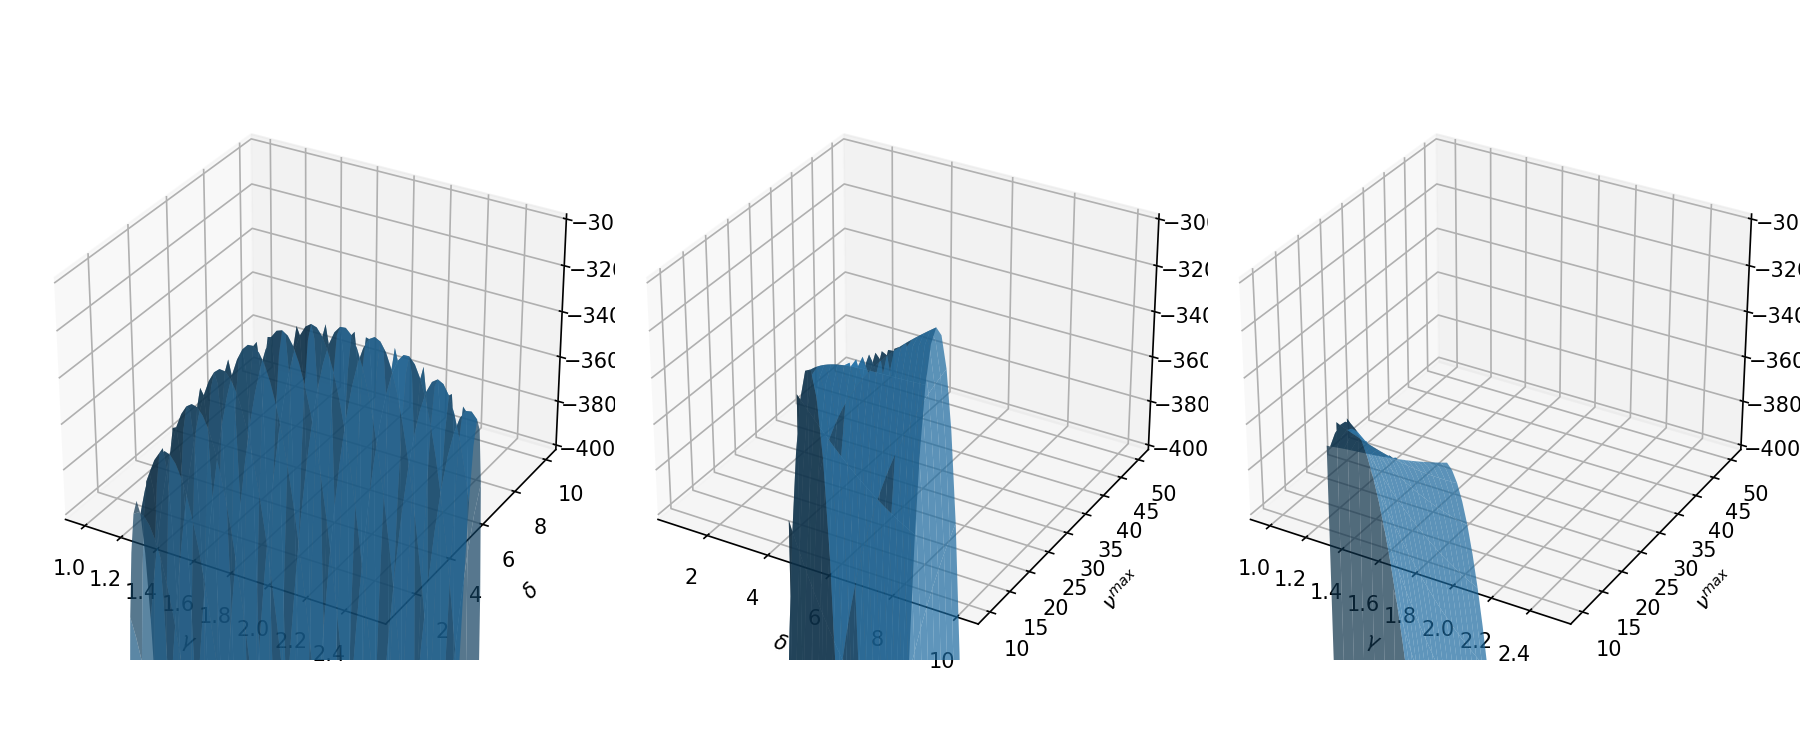

In [156]:
plt.close('all')
fig = plt.figure(figsize=(12,5),dpi=150)
ax_nu = fig.add_subplot(131,projection='3d')
ax_gamma = fig.add_subplot(132,projection='3d')
ax_delta = fig.add_subplot(133,projection='3d')

plt.tight_layout()

@interact(i=(0,steps-1),j=(0,steps-1),k=(0,steps-1))
def update_3d(i=10,j=10,k=30):

    for axx in [ax_gamma,ax_delta,ax_nu]:
        axx.clear()
    ax_gamma.plot_surface(delta_mesh[i,...],nu_max_mesh[i,...],logl[i,...],alpha=0.7)
    ax_delta.plot_surface(gamma_mesh[:,j,:],nu_max_mesh[:,j,:],logl[:,j,:],alpha=0.7)
    ax_nu.plot_surface(gamma_mesh[...,k],delta_mesh[...,k],logl[:,:,k],alpha=0.7)#,cmap='viridis')#
    
    for axx in [ax_gamma,ax_delta,ax_nu]:
        plt.setp(axx,zlim=[-4000,-3000])
    
    plt.setp(ax_nu,xlabel='$\gamma$',ylabel='$\\delta$')
    plt.setp(ax_gamma,xlabel='$\delta$',ylabel='$\\nu^{max}$')
    plt.setp(ax_delta,xlabel='$\gamma$',ylabel='$\\nu^{max}$')
    
    print(f'$\\gamma=${gamma_array[i]}, $\\delta=${delta_array[j]}, $\\nu_m=${nu_max_array[k]}')
    fig.canvas.draw_idle()


In [70]:
plt.close('all')

In [167]:
steps = 101
gamma_arr = np.linspace(1.,2.5,steps)
delta_arr = np.linspace(1.,10.,steps)
nu_max = 25.
gamma_mesh,delta_mesh = np.meshgrid(gamma_arr,delta_arr)

logl_mesh = np.zeros((steps,steps))
for j in range(steps):
    # print(j,k)
    logl_mesh[:,j] = my_logl(np.vstack([gamma_mesh[:,j],delta_mesh[:,j],np.full(steps,nu_max)]).T)
# logl = my_logl(np.vstack([gamma_mesh[:,:,k],delta_mesh[:,:,k],nu_max_mesh[:,:,k]]).T)
logl_mesh

array([[  -11271.06241201,   -11543.26823172,   -11823.18867275, ...,
         -417043.52760609,  -417328.65230605,  -417617.30392126],
       [  -10473.71756052,   -10723.31684022,   -10980.33950374, ...,
         -415884.71683166,  -416149.80105895,  -416418.12039381],
       [   -9732.40320771,    -9960.94338572,   -10196.65477603, ...,
         -414843.91134725,  -415091.38245028,  -415341.83689704],
       ...,
       [ -500000.        ,  -500000.        ,  -500000.        , ...,
         -777591.96766058,  -721027.61582742,  -670672.22997688],
       [ -500000.        ,  -500000.        ,  -500000.        , ...,
         -915050.89654249,  -843677.35873957,  -780267.88317223],
       [ -500000.        ,  -500000.        ,  -500000.        , ...,
        -1087135.78043053,  -996902.60999696,  -916904.8271929 ]])

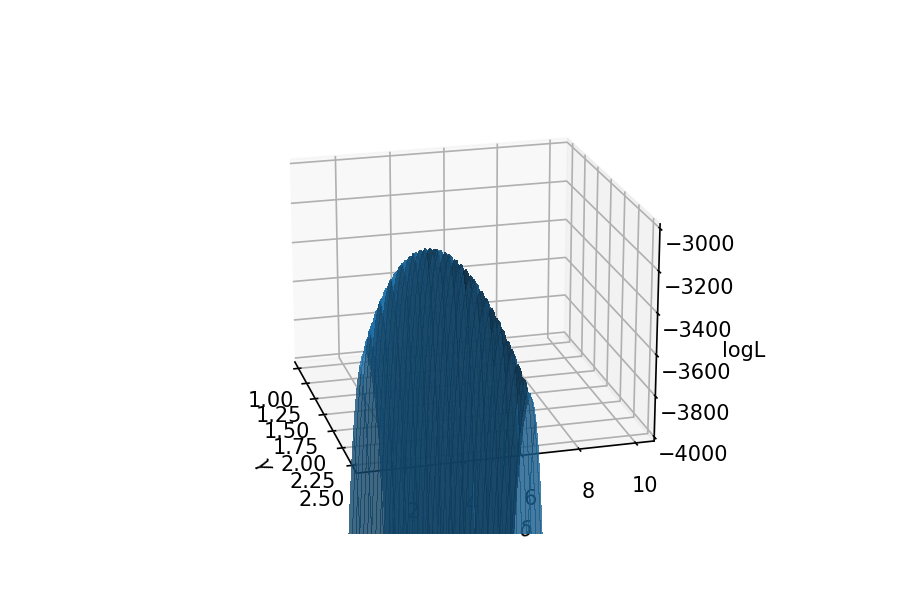

In [175]:
fig = plt.figure(figsize=(6,4),dpi=150)
ax = fig.add_subplot(111,projection='3d')

ax.plot_surface(gamma_mesh,delta_mesh,logl_mesh,alpha=0.8,antialiased=False)
plt.setp(ax,zlim=[-4000,-3000],xlabel='$\gamma$',ylabel='$\\delta$',zlabel='logL')
ax.view_init(20, -15)